# In-depth Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import adjusted_mutual_info_score, SCORERS
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split


import datetime as dt
import seaborn as sns
# df = pd.read_csv('./data/final_NYC_crimes.csv', parse_dates=[['DATE', 'TIME']])
df = pd.read_csv('./data/final_NYC_crimes.csv')

In [2]:
df.head()

,CMPLNT_NUM,DISTRICT,BOROUGH,DATE,TIME,CRM_ATPT_CPTD_CD,OFFENSE LEVEL,PREM_TYP_DESC,OFFENSE_NAME,SUSP_AGE_GROUP,...,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,YEAR,MONTH,DAY,CRIME_TYPE
0,314773184,48,BRONX,2019-12-31,18:00:00,COMPLETED,FELONY,STREET,ROBBERY,UNKNOWN,...,F,1016990,244612,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)",2019,12,31,ROBBERY
1,289837961,25,MANHATTAN,2019-12-30,20:30:00,COMPLETED,MISDEMEANOR,RESIDENCE - APT. HOUSE,PETIT LARCENY,UNKNOWN,...,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)",2019,12,30,LARCENY
2,535744284,77,BROOKLYN,2019-12-24,16:55:00,COMPLETED,FELONY,STREET,FELONY ASSAULT,UNKNOWN,...,M,1001068,183317,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)",2019,12,24,ASSAULT
3,895678119,52,BRONX,2019-12-30,19:32:00,COMPLETED,MISDEMEANOR,CHAIN STORE,PETIT LARCENY,25-44,...,D,1009690,257590,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)",2019,12,30,LARCENY
4,299841674,18,MANHATTAN,2019-12-30,15:30:00,COMPLETED,MISDEMEANOR,STREET,PETIT LARCENY,UNKNOWN,...,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)",2019,12,30,LARCENY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450978 entries, 0 to 450977
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CMPLNT_NUM        450978 non-null  int64  
 1   DISTRICT          450978 non-null  int64  
 2   BOROUGH           450978 non-null  object 
 3   DATE              450978 non-null  object 
 4   TIME              450978 non-null  object 
 5   CRM_ATPT_CPTD_CD  450978 non-null  object 
 6   OFFENSE LEVEL     450978 non-null  object 
 7   PREM_TYP_DESC     450978 non-null  object 
 8   OFFENSE_NAME      450978 non-null  object 
 9   SUSP_AGE_GROUP    450978 non-null  object 
 10  SUSP_RACE         450978 non-null  object 
 11  SUSP_SEX          450978 non-null  object 
 12  VIC_AGE_GROUP     450978 non-null  object 
 13  VIC_RACE          450978 non-null  object 
 14  VIC_SEX           450975 non-null  object 
 15  X_COORD_CD        450978 non-null  int64  
 16  Y_COORD_CD        45

#### Preparing the variables to be used.

In [4]:
# Step 1: Select columns of interest - Primary_Type, Arrest, Domestic, Location_Description, and Community_Area. 
crime_model = df[['CRIME_TYPE', 'PREM_TYP_DESC', 'BOROUGH', 'OFFENSE LEVEL', 'DISTRICT']]

# Step 2: Divide dataset into inputs (crime_x) and output variable (crime_y)
crime_x = crime_model[['PREM_TYP_DESC', 'BOROUGH', 'DISTRICT', 'OFFENSE LEVEL']]
crime_y = crime_model[['CRIME_TYPE']]

# Step 3: One-hot encode categorical inputs in crime_x 
crime_x.loc[:, 'BOROUGH'] = pd.factorize(crime_x['BOROUGH'])[0].reshape(-1,1)
crime_x.loc[:, 'OFFENSE LEVEL'] = pd.factorize(crime_x['OFFENSE LEVEL'])[0].reshape(-1,1)
crime_x.loc[:, 'DISTRICT'] = pd.factorize(crime_x['DISTRICT'])[0].reshape(-1,1)
crime_x.loc[:, 'PREM_TYP_DESC'] = pd.factorize(crime_x['PREM_TYP_DESC'])[0].reshape(-1,1)

crime_x = pd.get_dummies(crime_x)
crime_x_col_names = list(crime_x.columns.values)

# pd.factorize(crime_y['CRIME_TYPE'])

# Step 4: Recode crime_y to convert data from categorical labels to numeric 
crime_y.loc[:, 'CRIME_TYPE_CODE'] = pd.factorize(crime_y['CRIME_TYPE'])[0].reshape(-1,1)
crime_y = crime_y[['CRIME_TYPE_CODE']]

# print('0',crime_y)

# # Step 5
crime_x = np.array(crime_x)
crime_y = np.array(crime_y)

crime_y = crime_y.reshape(-1)

crime_y

# Step 6
# sss = StratifiedShuffleSplit(n_splits=3, test_size=0.20, random_state=0)
# sss.get_n_splits(crime_x, crime_y)


# for train_index, test_index in sss.split(crime_x, crime_y):
#     print("TRAIN:", len(train_index), train_index, "TEST:", len(test_index),test_index)
#     X_train, X_test = crime_x[train_index], crime_x[test_index]
#     y_train, y_test = crime_y[train_index], crime_y[test_index]

# Step 6 using train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(crime_x, crime_y, train_size=0.8)



/Users/bea/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [5]:
Xtrain[2]

array([41,  0,  7,  0])

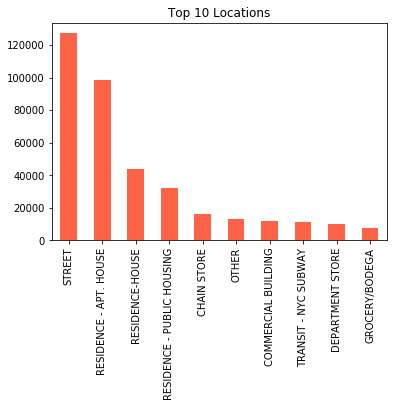

In [6]:
# Plot The top 10 crimes

crime_df10 = crime_model.CRIME_TYPE.value_counts().head(10)

crime_df10 = pd.DataFrame(crime_df10)

crime_df10 = crime_model.PREM_TYP_DESC.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Locations")
plt1.get_legend().remove()


#### Resampling method for multiclass data
Since we have skewed data, we want to resample data to make it balanced. 
The data is skewed somehow

In [8]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

# Using imblearn resampling methods from:
# https://heartbeat.fritz.ai/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning-64d82c16ceaa

from imblearn.under_sampling import RandomUnderSampler

# create the object.
under_sampler = RandomUnderSampler()

# Undersampling: fit the object to the training data.
x_train_under, y_train_under = under_sampler.fit_sample(Xtrain, ytrain)


/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([ 0,  0,  0, ..., 19, 19, 19])

#### Initiating logistic regression.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=200)
# Fit the model on the trainng data.
clf.fit(Xtrain, ytrain)
# Print the accuracy from the testing data.
score = (accuracy_score(clf.predict(Xtest), ytest))
print(score)

0.4554414829925939


/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Confusion matrix

In [ ]:
clf.predict(Xtest)
predictions = clf.predict(Xtest)

In [47]:
from sklearn import metrics
cm = metrics.confusion_matrix(ytest, predictions)

print(cm)

[[    0  2678     0     0     0     0     0     0     0     0     0     0
      0     0    31     0     0     0     0     0]
 [    0 26976     0     0     0     0     1     0     0     0     0     0
      0     0   105     0     0     0     0     0]
 [    0 14444     0     0     0     0     0     0     0     0     0     0
      0     0    63     0     0     0     0     0]
 [    0  1541     0     0     0     0     0     0     0     0     0     0
      0     0     5     0     0     0     0     0]
 [    0     2     0     0 14078     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0  2123     0     0     0     0     0     0     0     0     0     0
      0     0    31     0     0     0     0     0]
 [    0  2807     0     0     0     0     0     0     0     0     0     0
      0     0    19     0     0     0     0     0]
 [    0   837     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]


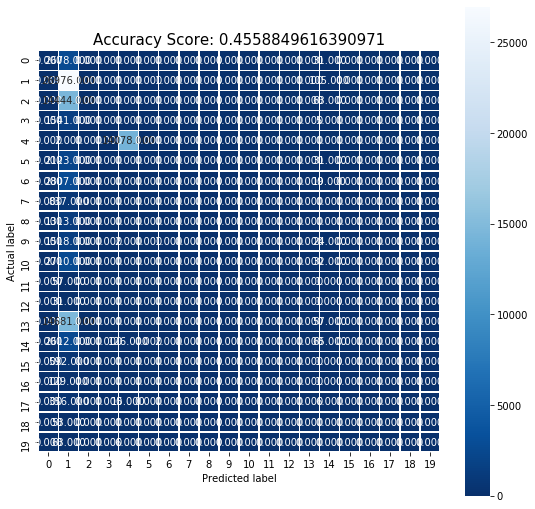

In [48]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [10]:
# Plot The top 10 crimes

crime_df10 = crime_model.CRIME_TYPE.value_counts().head(10)

crime_df10 = pd.DataFrame(crime_df10)

# plt1 = crime_df10.plot(kind="bar", color = "tomato")
# plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
# plt1.set_title("Top 10 Crimes")
# plt1.get_legend().remove()

crime_df10

,CRIME_TYPE
LARCENY,134122
OFFENSES_AGAINST_PUBLIC_ORDER,74031
ASSAULT,73102
HARRASSMENT,71000
MISC_PENAL_LAW,14048
BURGLARY,13973
POSSESSION_CONTROLLED_SUBSSTANCE,13367
ROBBERY,13325
FRAUD,10876
POSSESSION_WEAPON,7791


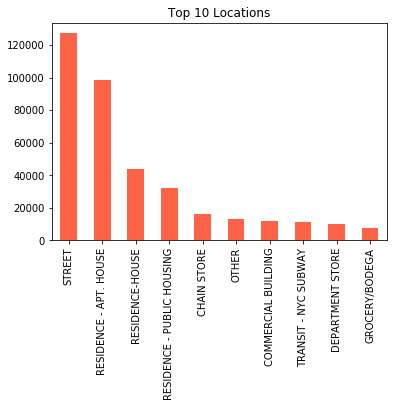

In [11]:
crime_df10 = crime_model.PREM_TYP_DESC.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Locations")
plt1.get_legend().remove()



In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

#### View ROC Curve : This  will be used for scoring our model

In [13]:
# View ROC Curve : This  will be used for scoring the 
def ez_roc(model, x, y, pos_label=1):
    """prints a basic Receivor Operator Curve (ROC). 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    pos_label --binary label considered positive in y  (dtype='int', default=1)
    """
    from sklearn.metrics import roc_curve, auc

    model_name=type(model).__name__ # defining model name as the __name__ characteristic held by sklearn models

    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC curve')
    ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return()

#### Random Forest¶
This function includes parameters for stratified cross-fold validation and supports code for hyperparameter tuning for a random forest model. Because we are working with a multi-classification problem, we evaluate our logistic regression models with one-vs-one classification.

In [14]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring = 'roc_auc_ovo_weighted', verbose=True, cv = True, 
                    return_train_score = True): 
    
    """function that uses GridSearchCV to test a specified param_grid of hyperparameters and choose the optimal one based on nfolds cross-validation results. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    X -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints a the roc_auc score from 10-fold crossvalidation (dtype='boolean', default='True')
    """
    
    np.random.seed(12345)
    
    # The scorers can be either be one of the predefined metric strings or a scorer
    # callable, like the one returned by make_scorer
#     scoring = {'AUC': 'roc_auc_ovr', 'Accuracy': make_scorer(accuracy_score)}

    grid_search = GridSearchCV(estimator= model,
                                     param_grid=param_grid,
                                     cv=KFold(nfolds), # stratified k-folds will preserve class balances - this function is what got the rest of the code to work with roc validation
                                     scoring=scoring,
                                     return_train_score=True,
                                     n_jobs = -1)
    
#     scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc_ovr'}
#     scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

    grid_search.fit(X, y)
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    
    return(grid_search)
#     print(grid_search.cv_results_)

In [16]:
# Random Forest


# Number of trees in random forest
n_estimators = [100]
# Number of features to consider at every split
max_features = ['auto'] # 'auto' which is equivalent to sqrt(n_features)
# Maximum number of levels in tree
max_depth = [5, 10]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

t1 = time.time()

model = RandomForestClassifier(criterion='entropy', random_state=12345)

In [17]:
rf_hyper = hypertuning_fxn(Xtrain, ytrain, nfolds = 5, model = model , param_grid = param_grid, scoring='roc_auc_ovo_weighted', cv = True, return_train_score = True)

t2 = time.time() 

run_time = t1 - t2
print('Training Time in Minutes:', run_time/60)

 scorer function: roc_auc_ovo_weighted
 ##### CV performance: mean & sd scores #####
best cv score: 0.825
best cv params:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
worst cv score: 0.791
worst cv params:  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.791 (+/-0.001) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.791 (+/-0.001) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.791 (+/-0.001) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.791 (+/-0.001) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.791 (+/-0.001) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples

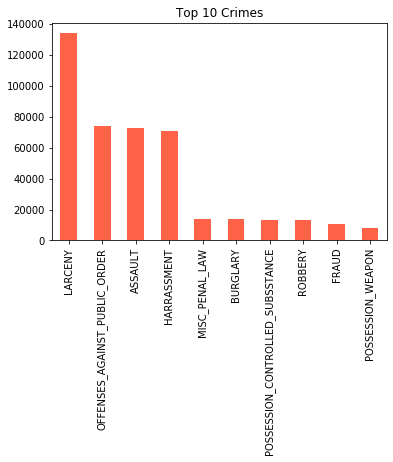

In [18]:
crime_df10 = crime_model.CRIME_TYPE.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Crimes")
plt1.get_legend().remove()


In [20]:
print(rf_hyper.best_estimator_)
rf = rf_hyper.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


In [35]:

def evaluate_model(model, x, y, cv = True):
    """prints common binary classification evaluation metrics and an ROC curve. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints  score from 5-fold crossvalidation (dtype='boolean', default='True')
    """
    import sklearn.metrics
    from sklearn.metrics import log_loss, average_precision_score, precision_recall_curve
    from sklearn.model_selection import cross_val_score


    if cv==True:
        cv_results= cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=Kfold(5))
        print("across 5 fold cv on trainingset, the model had \n", 
             "mean auroc: {:0.3f}".format(np.mean(cv_results)), "\n",
             "std auroc: {:0.3f}".format(np.std(cv_results))
             )

        base_cv_score=np.mean(cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=Kfold(5)))

    print("###metrics on provided dataset:###")
    
    ##basic model performance
    y_hat = model.predict(x) # predicted classes using default 0.5 threshold
    y_proba = model.predict_proba(x)[:,] #predicted probabilities
    auc=roc_auc_score(y, y_proba, multi_class = 'ovr', average = 'weighted')

    print ('the AUC is: {:0.3f}'.format(auc))
    
    # Modify labels for the classification reports
    crime_labels = list(range(0,11))
    crime_labels = np.asarray(crime_labels)
    
#     crime_names = df.CRIME_TYPE.tolist().drop_duplicates()
    
    print("classification report:\n ", classification_report(y, y_hat, labels = crime_labels, target_names = df['CRIME_TYPE'], digits=3))

    #ez_roc(model, x, y, pos_label = 1) #plotting roc curve
    #plt.show()

In [36]:
# Evaluating Training Data

evaluate_model(rf_hyper.best_estimator_, Xtrain, ytrain, cv=False)

###metrics on provided dataset:###
the AUC is: 0.829


/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1989: UserWarning: labels size, 11, does not match size of target_names, 450978
  .format(len(labels), len(target_names))
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification report:
                                    precision    recall  f1-score   support

                         ROBBERY      0.443     0.003     0.005     10616
                         LARCENY      0.425     0.846     0.566    107040
                         ASSAULT      0.342     0.219     0.267     58595
                         LARCENY      0.000     0.000     0.000      5989
                         LARCENY      0.991     1.000     0.995     56920
                         LARCENY      0.454     0.023     0.043      8722
                         ASSAULT      0.879     0.005     0.009     11147
                         ROBBERY      0.414     0.086     0.142      3529
                      SEX_CRIMES      0.498     0.023     0.044      5427
                     HARRASSMENT      0.455     0.014     0.026      6246
                     HARRASSMENT      0.341     0.149     0.207     10625

                       micro avg      0.518     0.571     0.543    284856
           

In [38]:
# Evaluating Testing Data

evaluate_model(rf_hyper.best_estimator_, Xtest, ytest, cv = False)

###metrics on provided dataset:###
the AUC is: 0.830
classification report:
                                    precision    recall  f1-score   support

                         ROBBERY      0.500     0.003     0.007      2709
                         LARCENY      0.432     0.852     0.573     27082
                         ASSAULT      0.347     0.225     0.273     14507
                         LARCENY      0.000     0.000     0.000      1546
                         LARCENY      0.990     1.000     0.995     14080
                         LARCENY      0.429     0.021     0.040      2154
                         ASSAULT      0.800     0.004     0.008      2826
                         ROBBERY      0.357     0.078     0.128       837
                      SEX_CRIMES      0.492     0.024     0.046      1313
                     HARRASSMENT      0.333     0.010     0.019      1545
                     HARRASSMENT      0.336     0.137     0.195      2742

                       micro avg

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1989: UserWarning: labels size, 11, does not match size of target_names, 450978
  .format(len(labels), len(target_names))
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
